In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

## Geo Exploratory

In [2]:
geo_data = pd.read_csv('data1/olist_geolocation_dataset.csv')

In [3]:
geo_data.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [5]:
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib
from mpl_toolkits.basemap import Basemap

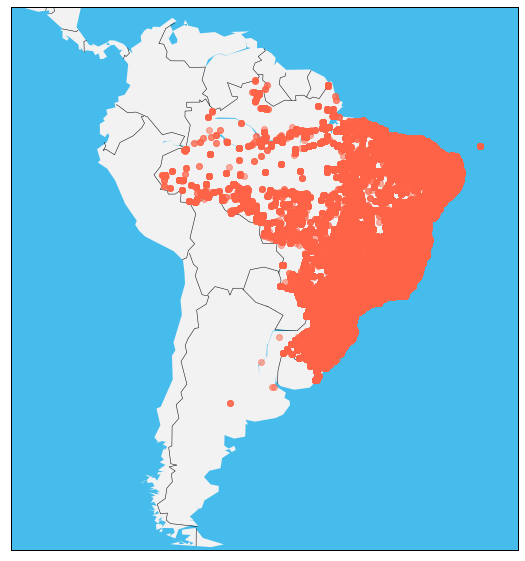

In [6]:
lat = geo_data['geolocation_lat']
lon = geo_data['geolocation_lng']

plt.figure(figsize=(10,10))

m = Basemap(llcrnrlat=-55.401805,llcrnrlon=-92.269176,urcrnrlat=13.884615,urcrnrlon=-27.581676)
m.bluemarble()
m.drawmapboundary(fill_color='#46bcec') # Make your map into any style you like
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec') # Make your map into any style you like
#m.drawcoastlines()
m.drawcountries()
m.scatter(lon, lat,zorder=10,alpha=0.5,color='tomato')

- 브라질의 인구를 살펴보면 대부분의 인구가 동해안에 거주하고 일부는 서쪽에 더 많이 거주
- 인구에 대한 세부 정보 : [Brazil Population 2021 (Demographics, Maps, Graphs)](https://worldpopulationreview.com/countries/brazil-population#popDensityMap)
- 위의 지도는 구매한 상품의 주문 위치
- 인구 분포에 따라 동해안에서 가장 높은 쇼핑률을 나타냄

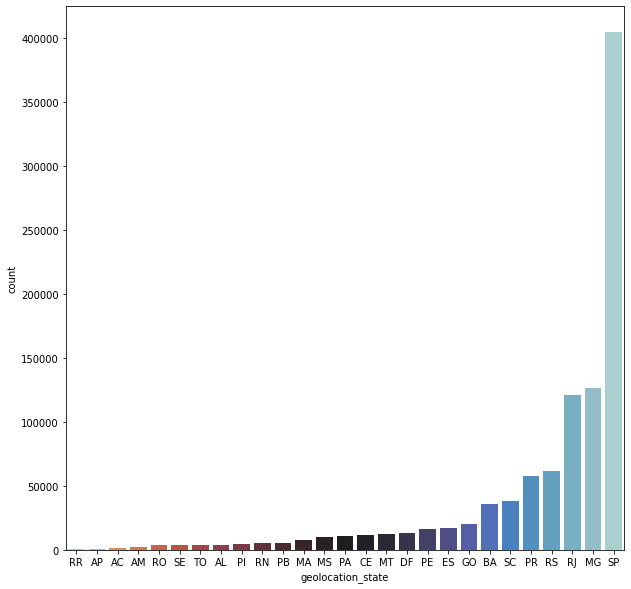

In [7]:
plt.figure(figsize=(10,10))
sns.countplot(x ='geolocation_state', data=geo_data, 
              order=geo_data['geolocation_state'].value_counts().sort_values().index, 
              palette='icefire_r')

- 위의 그래프는 주에 따라 구매한 제품 주문 수
- 상파울루가 가장 높은 비율을 보이고 있으며 나머지 주 사이에는 큰 격차가 있음

## Data Exploratory

### Order Data

In [9]:
order_data = pd.read_csv('data1/olist_orders_dataset.csv')

In [10]:
order_data.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

#### Feature Enginering with Time

**결측값의 비율은 약 3%이므로 고객 날짜 기능의 Null 값은 forward-fill method로 채우기**
- 이 방법은 이전 값을 앞으로 전파

In [12]:
order_data['order_delivered_customer_date']= order_data['order_delivered_customer_date'].fillna(method='ffill')
order_data['order_delivered_customer_date'].isnull().sum()

0

**배달 시간 및 예상 시간 기능이 생성**

In [13]:
order_data['delivered_time']=pd.to_datetime(order_data['order_delivered_customer_date'],
                                            format='%Y-%m-%d').dt.date
order_data['estimate_time']=pd.to_datetime(order_data['order_estimated_delivery_date'], 
                                           format='%Y-%m-%d').dt.date

**주문 배송된 고객 날짜를 기준으로 Weekly 생성**

Weekly feature created based on order delivered customer date

In [15]:
order_data['weekly']=pd.to_datetime(order_data['order_delivered_customer_date'],
                                    format='%Y-%m-%d').dt.week

<ipython-input-15-7141a3e5f4d0>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  order_data['weekly']=pd.to_datetime(order_data['order_delivered_customer_date'],


**주문 배송된 고객 날짜를 기반으로 Monthly 생성**

Monthly feature created based on order delivered customer date

In [59]:
order_data['monthly']=pd.to_datetime(order_data['order_delivered_customer_date'])\
                    .dt.to_period('M')
order_data['monthly']= order_data['monthly'].astype(str)

**예상 날짜와 배송된 날짜의 차이로 diff_days 생성**

Finding different days of delivered and estimated times.

In [17]:
order_data['diff_days']= order_data['delivered_time']-order_data['estimate_time']
order_data['diff_days']= order_data['diff_days'].dt.days

In [29]:
# 배송완료 예정 날짜보다 늦게 배송된 경우
order_data[order_data['diff_days']>0].shape

(8147, 13)

In [31]:
# 배송완료 예정 날짜 = 실제 배송완료 날짜
order_data[order_data['diff_days']==0].shape

(1298, 13)

In [30]:
# 배송완료 예정 날짜보다 빨리 배송된 경우
order_data[order_data['diff_days']<0].shape

(89996, 13)

In [56]:
order_data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivered_time,estimate_time,weekly,yearly,diff_days
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2017-10-10,2017-10-18,41,2017-10,-8
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,2018-08-07,2018-08-13,32,2018-08,-6
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,2018-08-17,2018-09-04,33,2018-08,-18
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,2017-12-02,2017-12-15,48,2017-12,-13
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,2018-02-16,2018-02-26,7,2018-02,-10


In [66]:
order_data.groupby(['weekly'])["diff_days"].mean()

weekly
1     -7.410565
2     -9.545106
3    -12.558468
4    -12.884390
5    -15.380216
6    -15.409619
7    -15.808038
8    -12.847575
9    -10.312367
10    -8.705539
11    -8.843194
12    -6.942418
13    -6.749074
14    -7.710134
15    -6.829278
16    -7.992713
17    -6.820391
18    -9.235779
19    -8.664632
20    -9.623836
21    -9.667952
22   -12.225806
23   -10.901163
24   -14.594203
25   -14.497691
26   -11.191816
27   -11.646897
28   -10.517302
29   -12.283157
30    -9.231623
31    -8.039057
32    -6.955309
33    -3.494004
34    -5.808483
35    -6.493061
36   -13.044720
37   -11.419561
38    -7.588561
39   -14.229000
40   -14.530890
41   -18.221221
42   -14.519019
43   -14.862682
44   -13.229189
45   -13.835806
46   -12.332604
47   -11.132440
48   -11.260595
49   -10.927772
50   -12.168146
51    -9.761956
52   -11.362107
Name: diff_days, dtype: float64

Text(0.5, 1.0, 'Average Difference Days per Week')

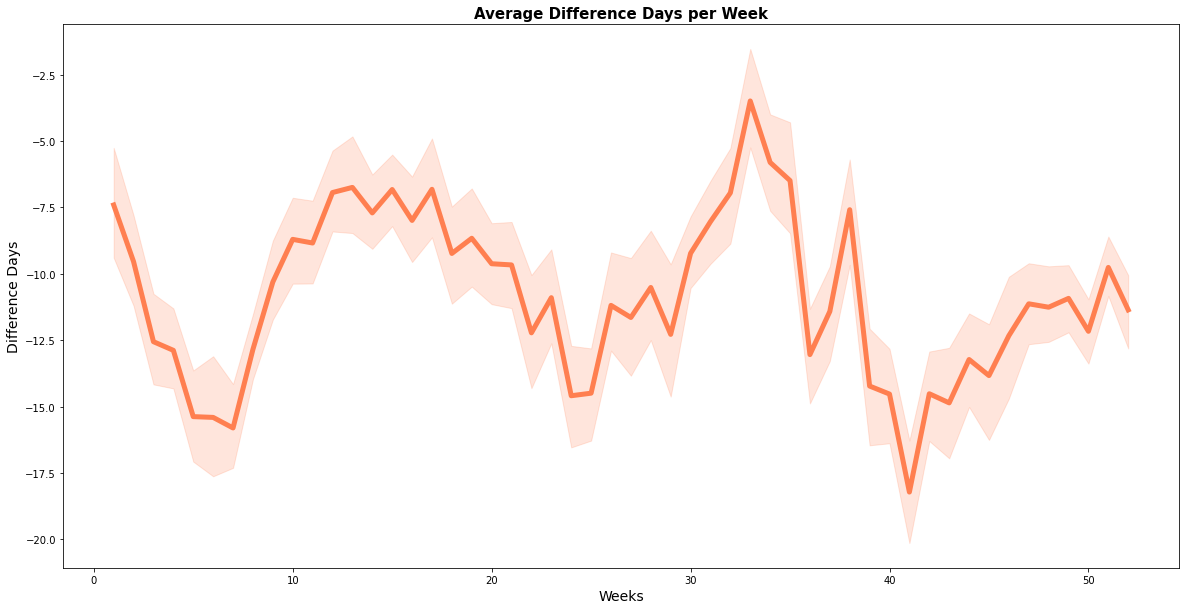

In [22]:
plt.figure(figsize=(20,10))
sns.lineplot(x='weekly', y='diff_days', data=order_data, color="coral", linewidth=5,
            markers=True,dashes=False, estimator='mean')

plt.xlabel("Weeks", size=14)
plt.ylabel("Difference Days", size=14)
plt.title("Average Difference Days per Week",size=15, weight='bold')

- 위의 그래프는 가장 빠른 배송과 가장 늦은 배송을 보여줌
- 모든 배송은 예상 날짜 이전에 이루어짐

- 가장 빠른 배송은 10월에 이루어졌습니다. 이것은 이번 달이 그 해 중 가장 덜 집중적인 기간이라는 것을 의미
- 늦은 배송은 6월 말과 8월 초에 이루어졌습니다. 이 시기가 그 해 중 가장 집중적인 시기라는 것을 의미

In [67]:
order_data.groupby(['monthly'])["diff_days"].mean()

monthly
2016-10   -50.727700
2016-11   -42.828125
2016-12    -7.250000
2017-01   -40.935154
2017-02   -31.612069
2017-03   -19.071458
2017-04   -18.632945
2017-05   -18.184047
2017-06   -17.470057
2017-07   -16.145347
2017-08   -16.555806
2017-09   -12.108802
2017-10   -13.829442
2017-11   -11.464821
2017-12   -11.135602
2018-01   -10.348374
2018-02    -9.800795
2018-03    -4.447050
2018-04    -4.647415
2018-05    -5.359483
2018-06   -10.282149
2018-07    -7.021156
2018-08    -0.191398
2018-09    22.553571
2018-10    83.666667
Name: diff_days, dtype: float64

Text(0.5, 1.0, 'Average Difference Days per Month')

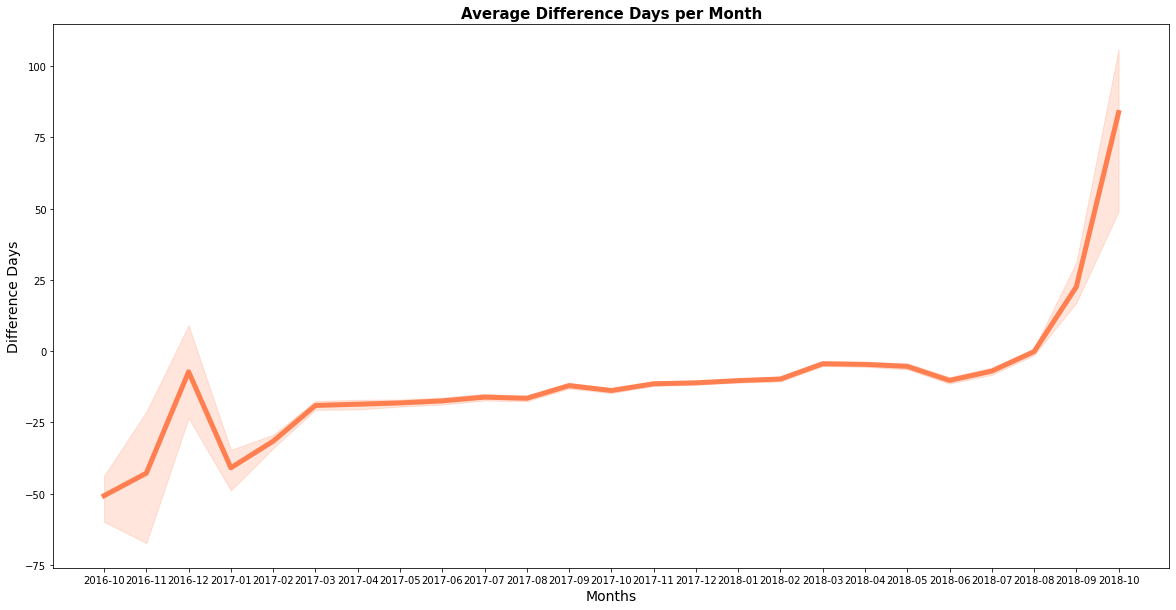

In [60]:
order_data1 = order_data
order_data1 = order_data.sort_values('monthly')

plt.figure(figsize=(20,10))
sns.lineplot(x='monthly', y='diff_days', data=order_data1, color="coral", linewidth=5,
            markers=True,dashes=False,estimator='mean')

plt.xlabel("Months", size=14)
plt.ylabel("Difference Days", size=14)
plt.title("Average Difference Days per Month",size=15, weight='bold')

## Customer Top 10 Product
**고객 상위 10개 제품**

In [77]:
# Upload Olist_Order_Items and Product Data
order_item_data = pd.read_csv('data1/olist_order_items_dataset.csv')
products_data = pd.read_csv('data1/olist_products_dataset.csv')

In [78]:
#Merge data
total_orders=pd.merge(order_data, order_item_data)
product_orders=pd.merge(total_orders,products_data, on="product_id")
product_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       112650 non-null  object 
 1   customer_id                    112650 non-null  object 
 2   order_status                   112650 non-null  object 
 3   order_purchase_timestamp       112650 non-null  object 
 4   order_approved_at              112635 non-null  object 
 5   order_delivered_carrier_date   111456 non-null  object 
 6   order_delivered_customer_date  112650 non-null  object 
 7   order_estimated_delivery_date  112650 non-null  object 
 8   delivered_time                 112650 non-null  object 
 9   estimate_time                  112650 non-null  object 
 10  weekly                         112650 non-null  int64  
 11  yearly                         112650 non-null  object 
 12  diff_days                     

**product_id 값 이름이 길기 때문에 분석을 위해 줄이기**
- 마지막 8자만 가져오기 (고유성이 유지되는지 확인)

In [93]:
len(product_orders['product_id'].unique())

32951

In [94]:
len(product_orders['product_id'].str[-8:].unique())

32951

In [95]:
product_orders['product_id_shorten']=product_orders['product_id'].str[-8:]

Text(0.5, 1.0, 'Top 10 Products')

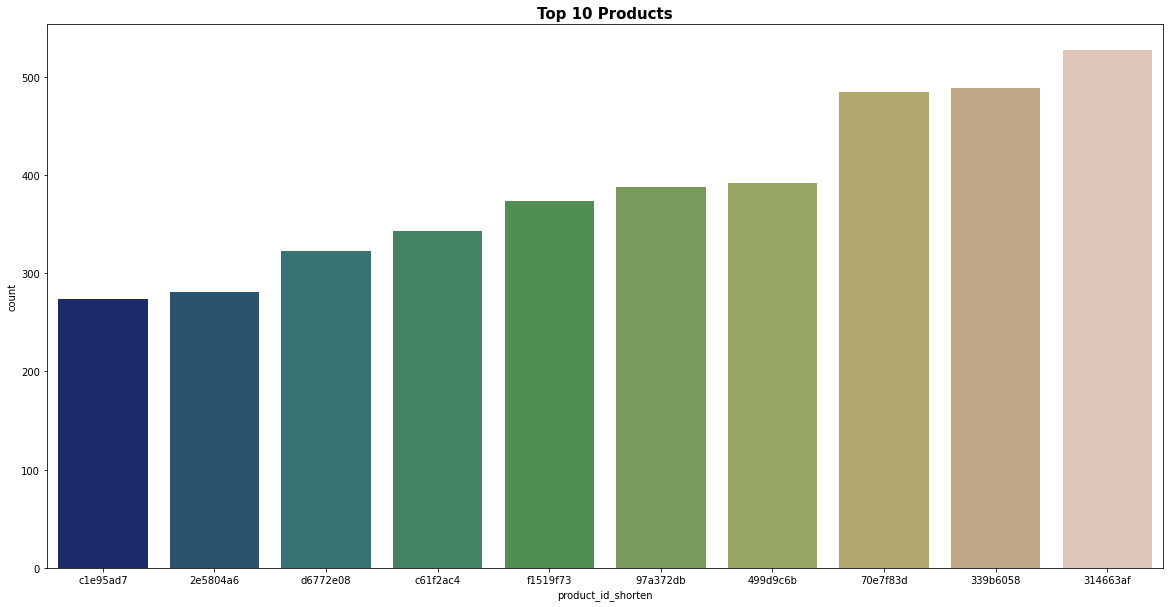

In [96]:
#Plotting Top 10 Products
plt.figure(figsize=(20,10))
sns.countplot(x='product_id_shorten', data=product_orders, palette='gist_earth',
             order=product_orders['product_id_shorten'].value_counts()[:10]\
             .sort_values().index).set_title("Top 10 Products", fontsize=15,
                                             weight='bold')

- 위의 그래프는 상위 10개 제품을 보여줌
- 상위 3개 제품은 다른 제품과 상당한 차이가 있음
- 데이터 정보로 인해 이러한 제품이 무엇인지 알 수 없지만 카테고리에 대해 추측할 수 있음

In [128]:
group_category= product_orders.groupby(['product_id_shorten','product_category_name',])['product_id_shorten']\
                                        .count().sort_values(ascending=False).head(10)
group_category

product_id_shorten  product_category_name 
314663af            moveis_decoracao          527
339b6058            cama_mesa_banho           488
70e7f83d            ferramentas_jardim        484
499d9c6b            ferramentas_jardim        392
97a372db            ferramentas_jardim        388
f1519f73            ferramentas_jardim        373
c61f2ac4            informatica_acessorios    343
d6772e08            relogios_presentes        323
2e5804a6            beleza_saude              281
c1e95ad7            informatica_acessorios    274
Name: product_id_shorten, dtype: int64

- 아래에서 1위 카테고리는 bed_table_bath이지만, 1위 제품의 카테고리는 홈 데코레이션

### Customer Top 10 category_name
**고객 상위 10개 카테고리**

In [112]:
product_orders.groupby(["product_category_name"])["product_id_shorten"].count().sort_values(ascending=False).head(10)

product_category_name
cama_mesa_banho           11115
beleza_saude               9670
esporte_lazer              8641
moveis_decoracao           8334
informatica_acessorios     7827
utilidades_domesticas      6964
relogios_presentes         5991
telefonia                  4545
ferramentas_jardim         4347
automotivo                 4235
Name: product_id_shorten, dtype: int64

- 테이블에 따르면 bed_table_bath 카테고리 주문이 가장 높습니다.

## Top 10 Seller
**상위 10명의 판매자**

In [129]:
sellers_data = pd.read_csv('data1/olist_sellers_dataset.csv')

In [130]:
#First seller dataset will be merged with the product orders data.
seller_products = pd.merge(product_orders, sellers_data, on="seller_id")
seller_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       112650 non-null  object 
 1   customer_id                    112650 non-null  object 
 2   order_status                   112650 non-null  object 
 3   order_purchase_timestamp       112650 non-null  object 
 4   order_approved_at              112635 non-null  object 
 5   order_delivered_carrier_date   111456 non-null  object 
 6   order_delivered_customer_date  112650 non-null  object 
 7   order_estimated_delivery_date  112650 non-null  object 
 8   delivered_time                 112650 non-null  object 
 9   estimate_time                  112650 non-null  object 
 10  weekly                         112650 non-null  int64  
 11  yearly                         112650 non-null  object 
 12  diff_days                     

**product id처럼 seller id도 줄이기**
- 마지막 6자만 가져오기 (고유성이 유지되는지 확인)

In [131]:
len(seller_products['seller_id'].unique())

3095

In [132]:
len(seller_products['seller_id'].str[-6:].unique())

3095

In [133]:
seller_products['seller_id_shorten']=seller_products['seller_id'].str[-6:]

**Customer Top 10 Seller**
- 상위 3명의 판매자는 비율이 비슷

Text(0.5, 1.0, 'Top 10 Seller')

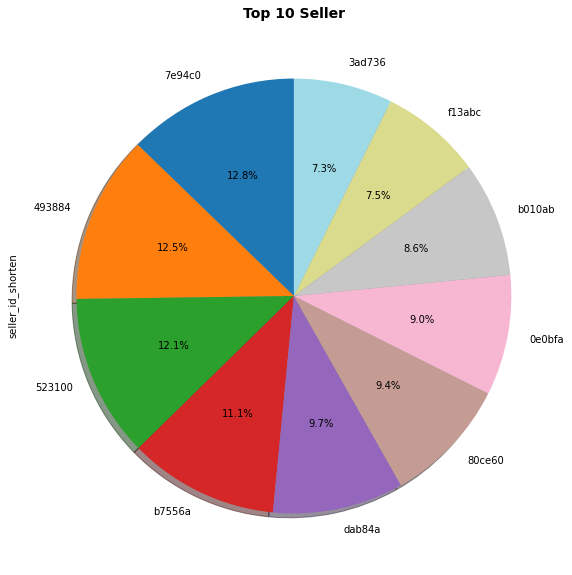

In [134]:
plt.figure(figsize=(20,10))
seller_products['seller_id_shorten'].value_counts()[:10].plot.pie(autopct='%1.1f%%',
        shadow=True, startangle=90, cmap='tab20')
plt.title("Top 10 Seller",size=14, weight='bold')


이러한 판매자의 주문 상품 카테고리를 가정하면 '상품 카테고리' 값을 사용할 수 있습니다. 아래 표는 Top 10 Seller 카테고리로, 다양한 종류의 제품을 판매할 수 있어 정원용 도구가 베스트 셀러 중 가장 많이 팔리는 제품입니다.

### Top 10 sellers Product category
**Top 10 Seller 제품 카테고리**

In [135]:
seller_category= seller_products.groupby(['seller_id_shorten', 'product_category_name'])\
                        ['seller_id_shorten'].count().sort_values(ascending=False).head(10)
seller_category

seller_id_shorten  product_category_name
523100             ferramentas_jardim       1882
7e94c0             relogios_presentes       1628
493884             cama_mesa_banho          1572
0e0bfa             moveis_decoracao         1292
dab84a             cama_mesa_banho          1277
b010ab             moveis_escritorio        1233
f13abc             telefonia                1178
b7556a             beleza_saude             1091
3ad736             cool_stuff               1069
3b52b2             relogios_presentes       1002
Name: seller_id_shorten, dtype: int64

- 정원용 도구가 베스트 셀러 중 가장 많이 팔리는 카테고리

**top10 Products  &  top10 Sellers Product category**
- 가장 많이 판매되는 제품의 카테고리는 가정 장식이지만 top seller의 가장 많이 판매되는 카테고리는 정원 도구

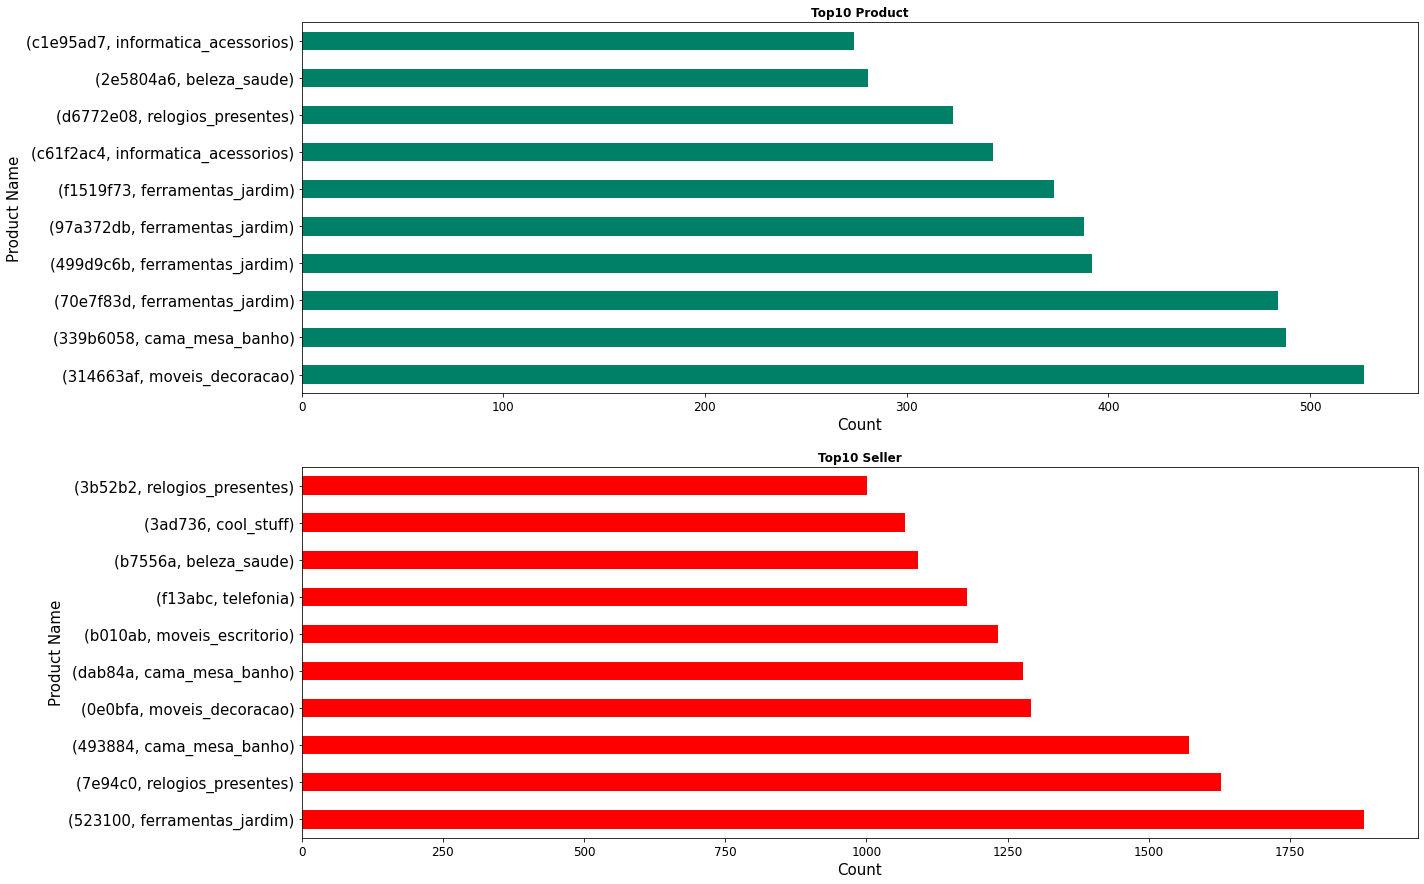

In [137]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,15))
group_category.plot.barh(ax=ax1, cmap='summer')
seller_category.plot.barh(ax=ax2, cmap='autumn')

ax1.set_title('Top10 Product', fontweight='bold')
ax2.set_title('Top10 Seller', fontweight='bold')

ax1.set_xlabel('Count', fontsize=15)
ax1.set_ylabel('Product Name', fontsize=15)
ax1.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=15)

ax2.set_xlabel('Count', fontsize=15)
ax2.set_ylabel('Product Name', fontsize=15)
ax2.xaxis.set_tick_params(labelsize=12)
ax2.yaxis.set_tick_params(labelsize=15)